# Identifying Pulsar Stars Using the HTRU2 Dataset
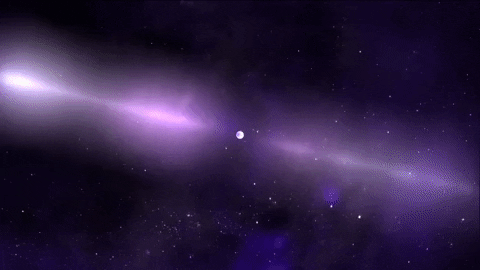

## Introduction

Pulsars are a rare type of Neutron star that are of significant scientific value to the physics community. By accurately measuring the time taken for radio waves emitted by these stars to reach earth, we can conduct various astrophysical experiments such as use them as probes of ISM (interstellar medium) to understand the unexplored galactic space that these waves travel through, use them as probes of space-time and even use them for gravitational wave detection in detecting other large celestial bodies in outer space. [Lyon 46-47].
 
As the pulsars rotate, their emission beam sweeps across the sky, and when this crosses our line of sight, produces a detectable pattern of broadband radio emission. As pulsars rotate rapidly, this pattern repeats periodically. Thus, pulsar search involves looking for periodic radio signals with large radio telescopes. However, the radio waves emitted by these stars are often hard to detect due to the radio frequency interference (RFI) and noise that make these stars difficult to find from observational data.
 
The aim of this project is to classify a given data signal into pulsars and non-pulsars by understanding if there exists a correlation between the given variables and their class. We predict that if these features are useful indicators of a star’s class, then they will produce accurate predictions when applied to the testing data by making a model. The HTRU2 data set is available in CSV and ARFF formats with variables listed first and then their class (0 indicating non-pulsars and 1 indicating pulsars) which contains 16,259 spurious examples caused by RFI/noise and 1,639 real pulsar examples that have been cross-checked by humans. The Integrated Profile (stable light intensity observations over time) and DM-SNR (ratio between Dispersion Measure and Signal to Noise ratio) values of pulsars along with statistical information such as their mean, standard deviation, excess kurtosis, and skewness help us deduce a model that we can use for pulsar classification.


#### What the Variables Represent:

**Mean of the *Integrated Profile***: This value represents the mean of the integrated profile which is the spectrum of electromagnetic radiation (radio waves) emitted from these pulsars over time.

**Standard Deviation of the *Integrated Profile***: This value tells us how spread the data points are from the mean integrated profile value.

**Excess kurtosis of the *Integrated Profile***: This describes the sharpness of the peak of the integrated graph profile.

**Skewness of the *Integrated Profile***:: This describes the asymmetry that deviates from the symmetrical bell curve in the data for the Integrated Profile.


**Mean of the *DM-SNR***:: This value represents the mean of the integrated profile which is the ratio between Dispersion Measure and Signal to Noise ratio.

**Standard Deviation of the *DM-SNR***:: This value tells us how spread the data points are from the mean DM-SNR value.

**Excess kurtosis of the *DM-SNR***:: This describes the sharpness of the peak of the DM-SNR graph.

**Skewness of the *DM-SNR***:: This describes the asymmetry that deviates from the symmetrical bell curve in the data for the DM-SNR.


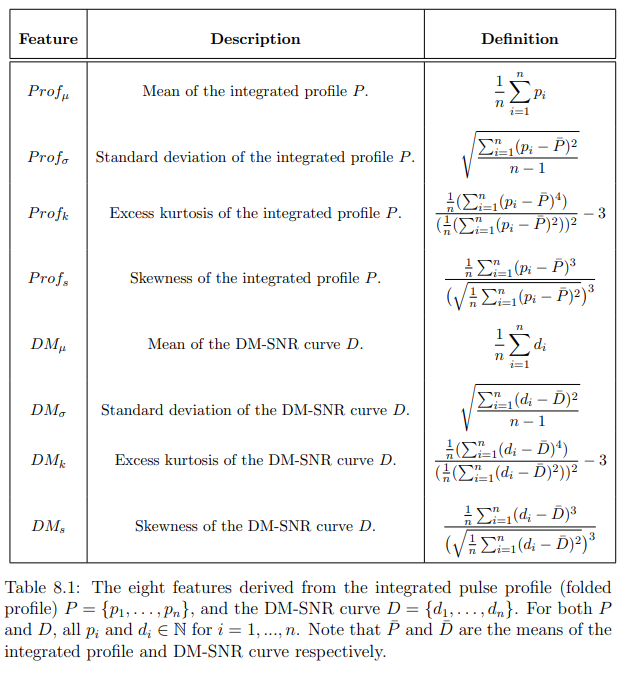

*Note. From “Why are pulsars hard to find?” by Lyon, R. J., Knowles, J., Brooke, J., & Stappers, B. (n.d.). (thesis), p.222*

## Preliminary Exploratory Data Analysis

In [17]:
install.packages("GGally")
install.packages("kknn")
install.packages("themis", type="binary")
install.packages("mlr")

Warning message in install.packages("GGally"):
“installation of package ‘GGally’ had non-zero exit status”
Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Warning message in install.packages("kknn"):
“installation of package ‘kknn’ had non-zero exit status”
Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



ERROR: Error in install.packages("themis", type = "binary"): type 'binary' is not supported on this platform


In [18]:
library(tidyverse)
library(GGally)
library(dplyr)
library(themis)
library(tidymodels)
library(kknn)

ERROR: Error in library(themis): there is no package called ‘themis’


#### First, let's load the dataset

In [19]:
# Set the seed for reproducibility
set.seed(27)

# Make column names
columns <- c("mean_integrated_profile", "std_integrated_profile", "kurtosis_integrated_profile",
             "skewness_integrated_profile", "mean_dmsnr", "std_dmsnr", 
             "kurtosis_dmsnr", "skewness_dmsnr", "class")

# Load the dataset
pulsar <- read_csv("https://raw.githubusercontent.com/garrethlee/DSCI-Group-Project/main/pulsar.csv", 
                   col_names = columns) %>%
            mutate(class=as_factor(class))

# Take a sneak peek into the data
head(pulsar)

Parsed with column specification:
cols(
  mean_integrated_profile = col_double(),
  std_integrated_profile = col_double(),
  kurtosis_integrated_profile = col_double(),
  skewness_integrated_profile = col_double(),
  mean_dmsnr = col_double(),
  std_dmsnr = col_double(),
  kurtosis_dmsnr = col_double(),
  skewness_dmsnr = col_double(),
  class = col_double()
)



mean_integrated_profile,std_integrated_profile,kurtosis_integrated_profile,skewness_integrated_profile,mean_dmsnr,std_dmsnr,kurtosis_dmsnr,skewness_dmsnr,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.56250,55.68378,-0.23457141,-0.6996484,3.199833,19.11043,7.975532,74.24222,0
102.50781,58.88243,0.46531815,-0.5150879,1.677258,14.86015,10.576487,127.39358,0
103.01562,39.34165,0.32332837,1.0511644,3.121237,21.74467,7.735822,63.17191,0
136.75000,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366,0
88.72656,40.67223,0.60086608,1.1234917,1.178930,11.46872,14.269573,252.56731,0
93.57031,46.69811,0.53190485,0.4167211,1.636288,14.54507,10.621748,131.39400,0


#### Let's then check for missing values within the dataset

In [20]:
total_missing_values <- sum(is.na(pulsar))
paste("There are", total_missing_values ,"missing values in the dataset")

[1] "There are 0 missing values in the dataset"

#### Then, we can summarize across columns to see key statistics, such as mean, max, min, median, etc.

In [21]:
key_statistics <- pulsar %>% 
                    select(mean_integrated_profile:skewness_dmsnr) %>% 
                    pivot_longer(everything(), names_to = "column") %>%
                    group_by(column) %>%
                    summarize(min=min(value), max=max(value), 
                              mean=mean(value), median=median(value), 
                              count=n(), missing_values=sum(is.na(.)))
key_statistics

`summarise()` ungrouping output (override with `.groups` argument)


column,min,max,mean,median,count,missing_values
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
kurtosis_dmsnr,-3.1392696,34.539844,8.3035561,8.4335147,17898,0
kurtosis_integrated_profile,-1.8760112,8.069522,0.4778573,0.2232400,17898,0
mean_dmsnr,0.2132107,223.392141,12.6143997,2.8018395,17898,0
mean_integrated_profile,5.8125000,192.617188,111.0799683,115.0781250,17898,0
skewness_dmsnr,-1.9769756,1191.000837,104.8577087,83.0645561,17898,0
skewness_integrated_profile,-1.7918860,68.101622,1.7702790,0.1987104,17898,0
std_dmsnr,7.3704322,110.642211,26.3265147,18.4613156,17898,0
std_integrated_profile,24.7720418,98.778911,46.5495316,46.9474791,17898,0


## Data Visualization

For this, I will be making a function, `plot_histogram`, that does a ggplot histogram for every column, except for the `class` column. This step provides an overall idea for the range and distribution of each variable.

[[1]]

[[2]]


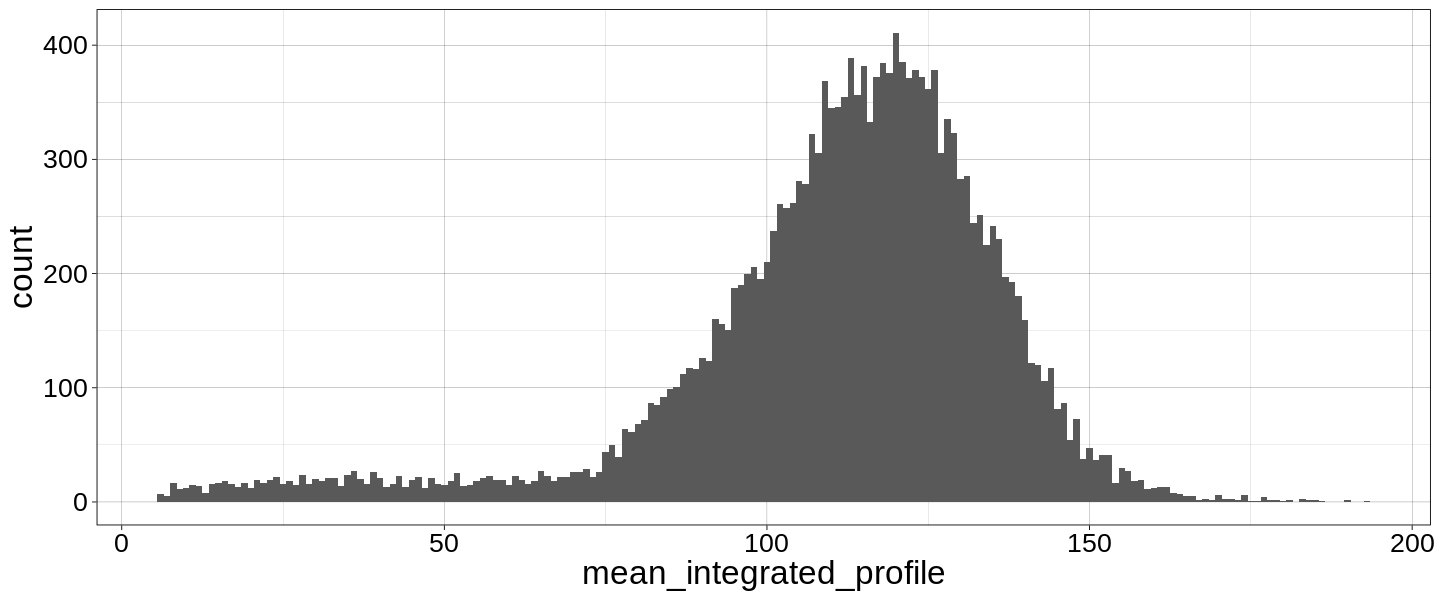


[[3]]


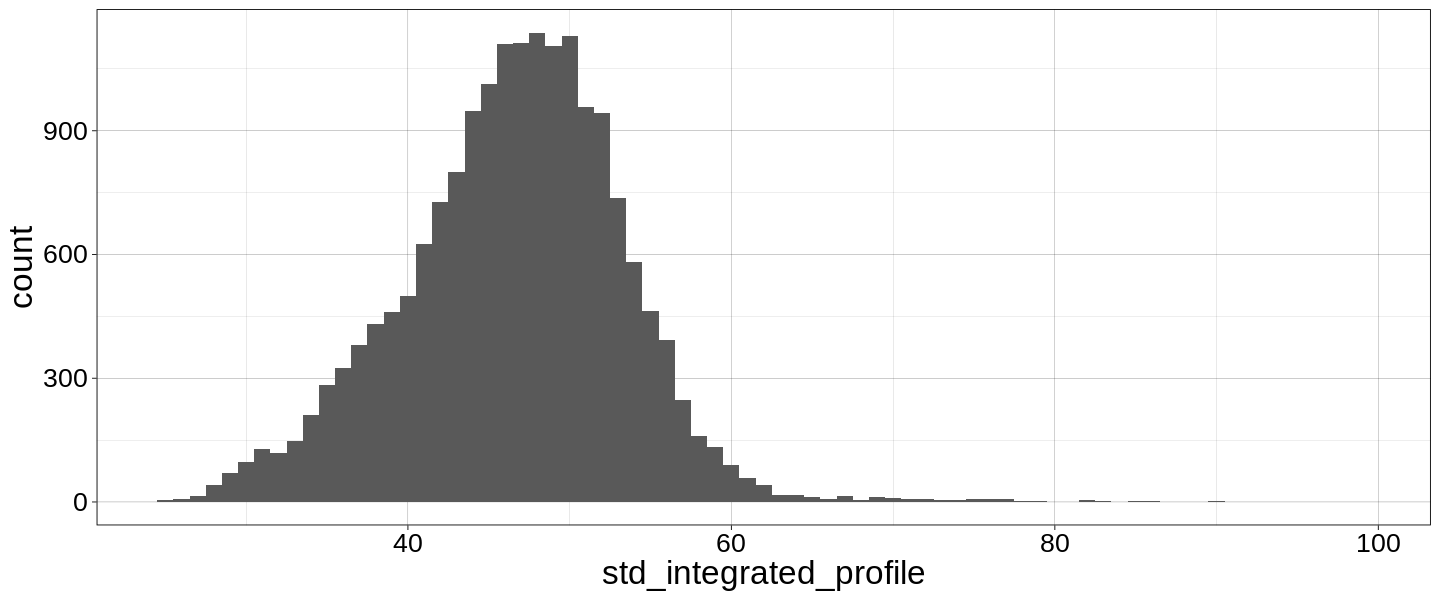


[[4]]


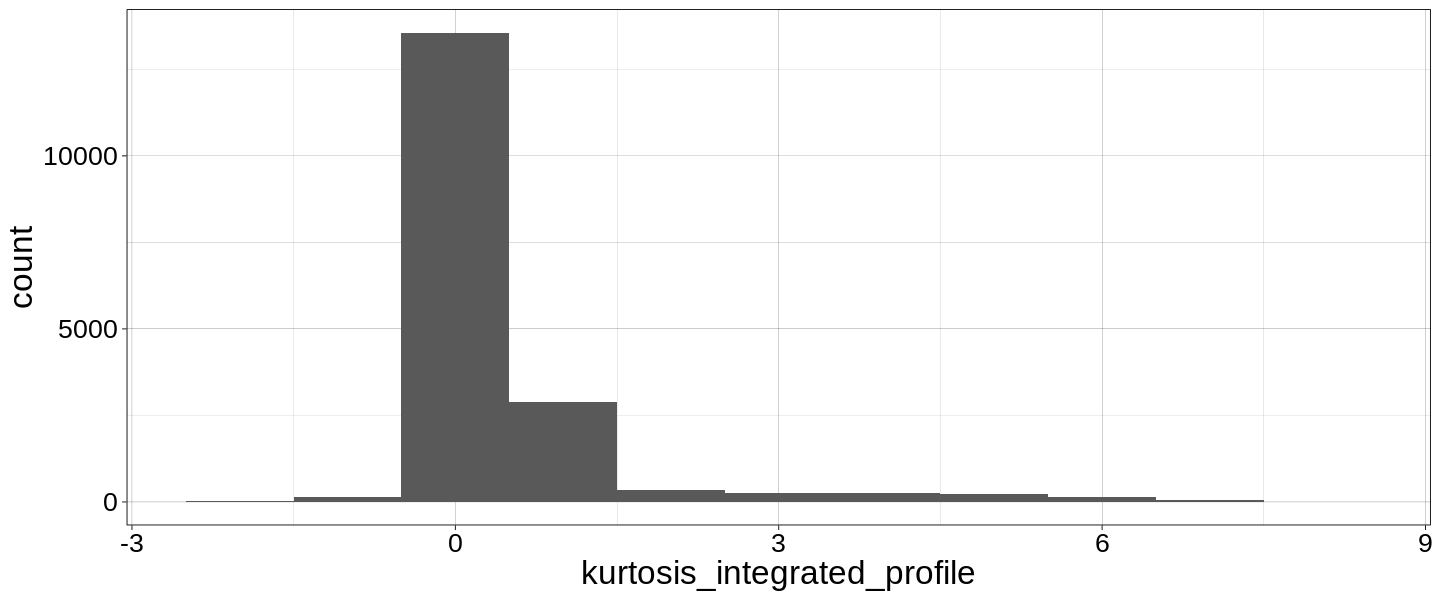


[[5]]


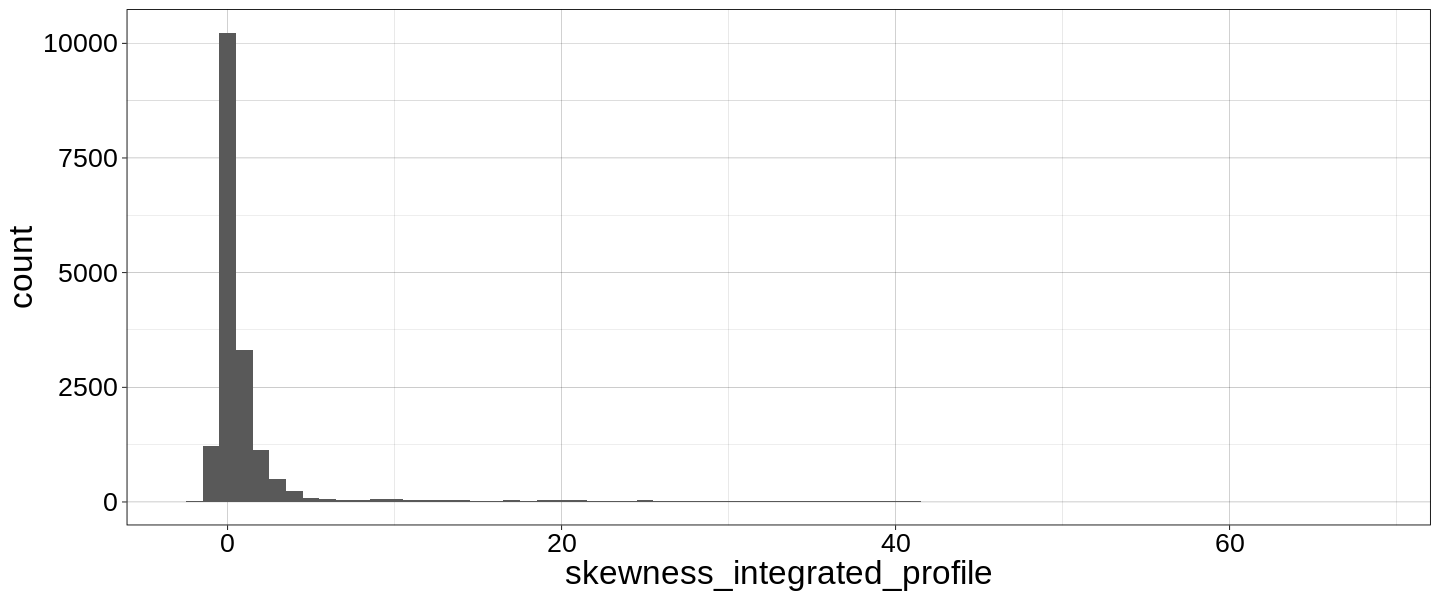


[[6]]


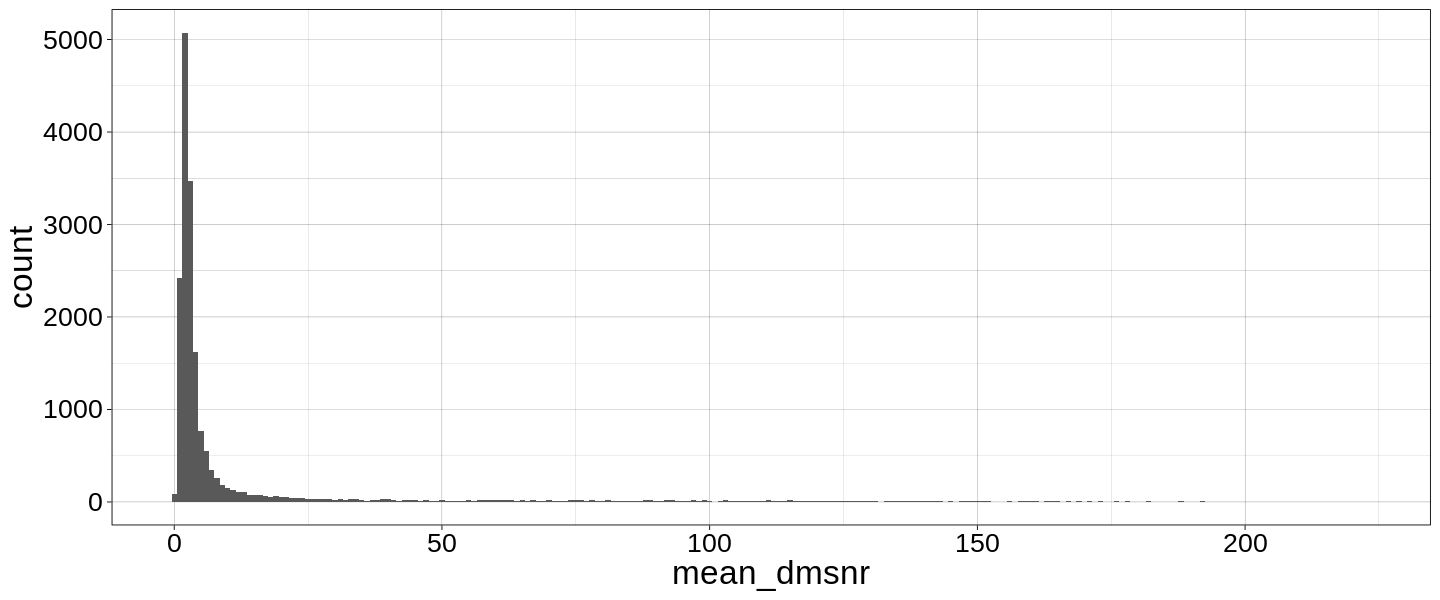


[[7]]


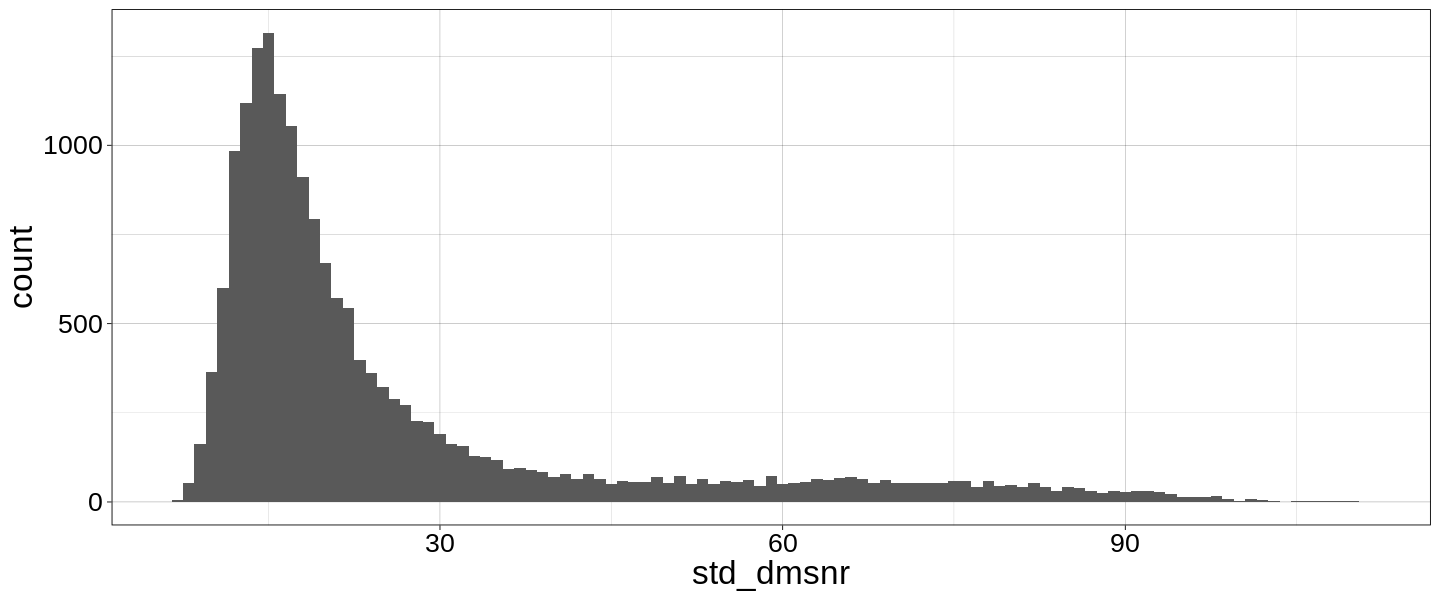


[[8]]


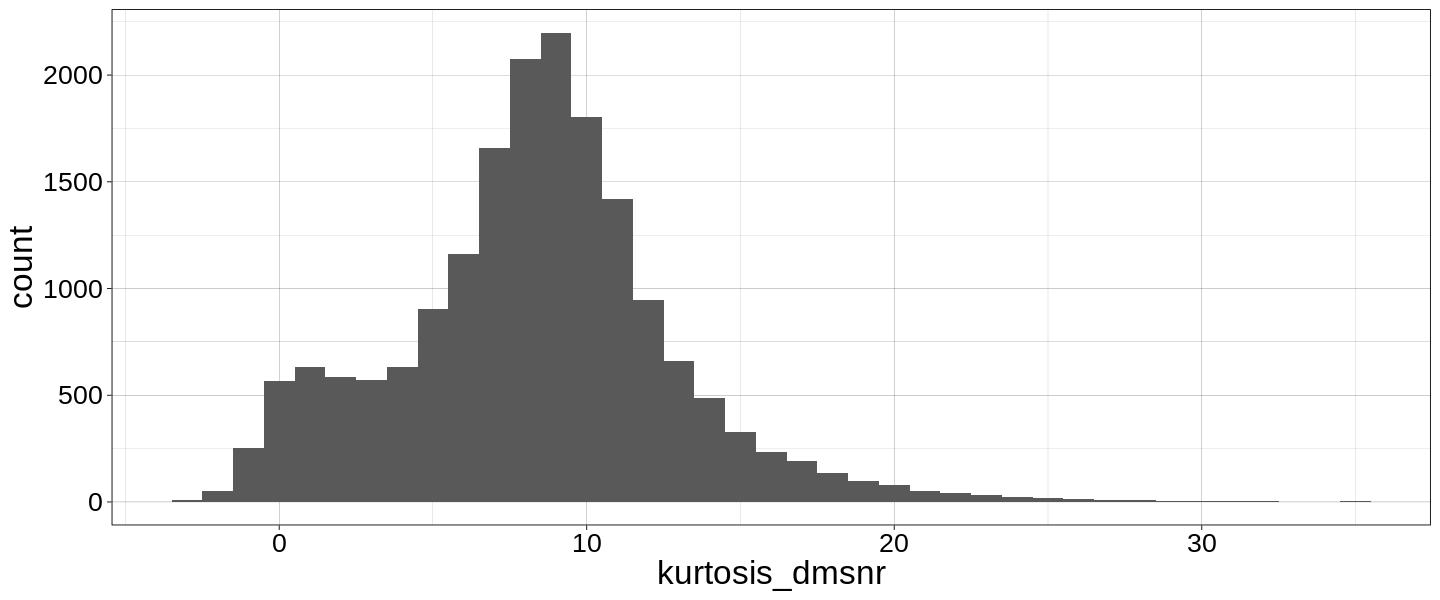

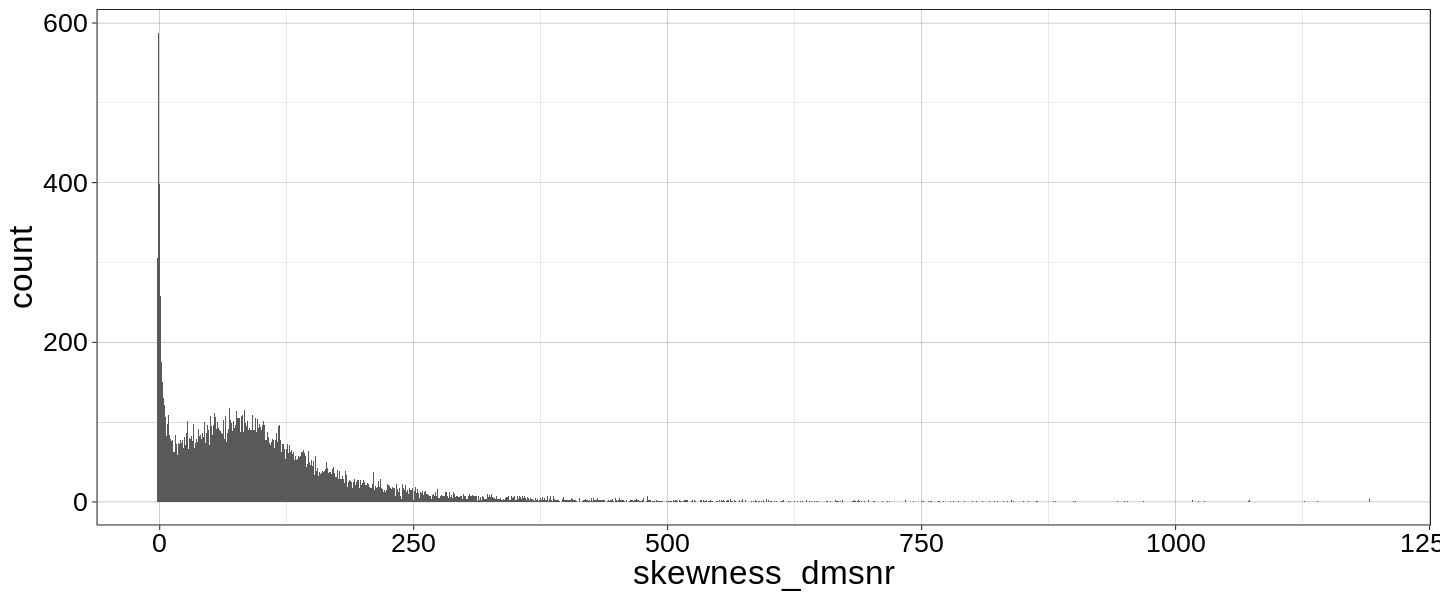

In [22]:
options(repr.plot.width=12, repr.plot.height=5)

columns_except_class <- columns[-9]

plot_histogram <- function(dataset, col){
    plot <- dataset %>% 
                ggplot(aes_string(x=col)) +
                geom_histogram(binwidth=1) +
                theme_linedraw() +
                theme(text=element_text(size=20)) 
    return(plot)
}

myplots <- lapply(columns_except_class, plot_histogram, data=pulsar)
show(myplots)

#### Now, let's see how the data is distributed across features based on the class of the observation

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



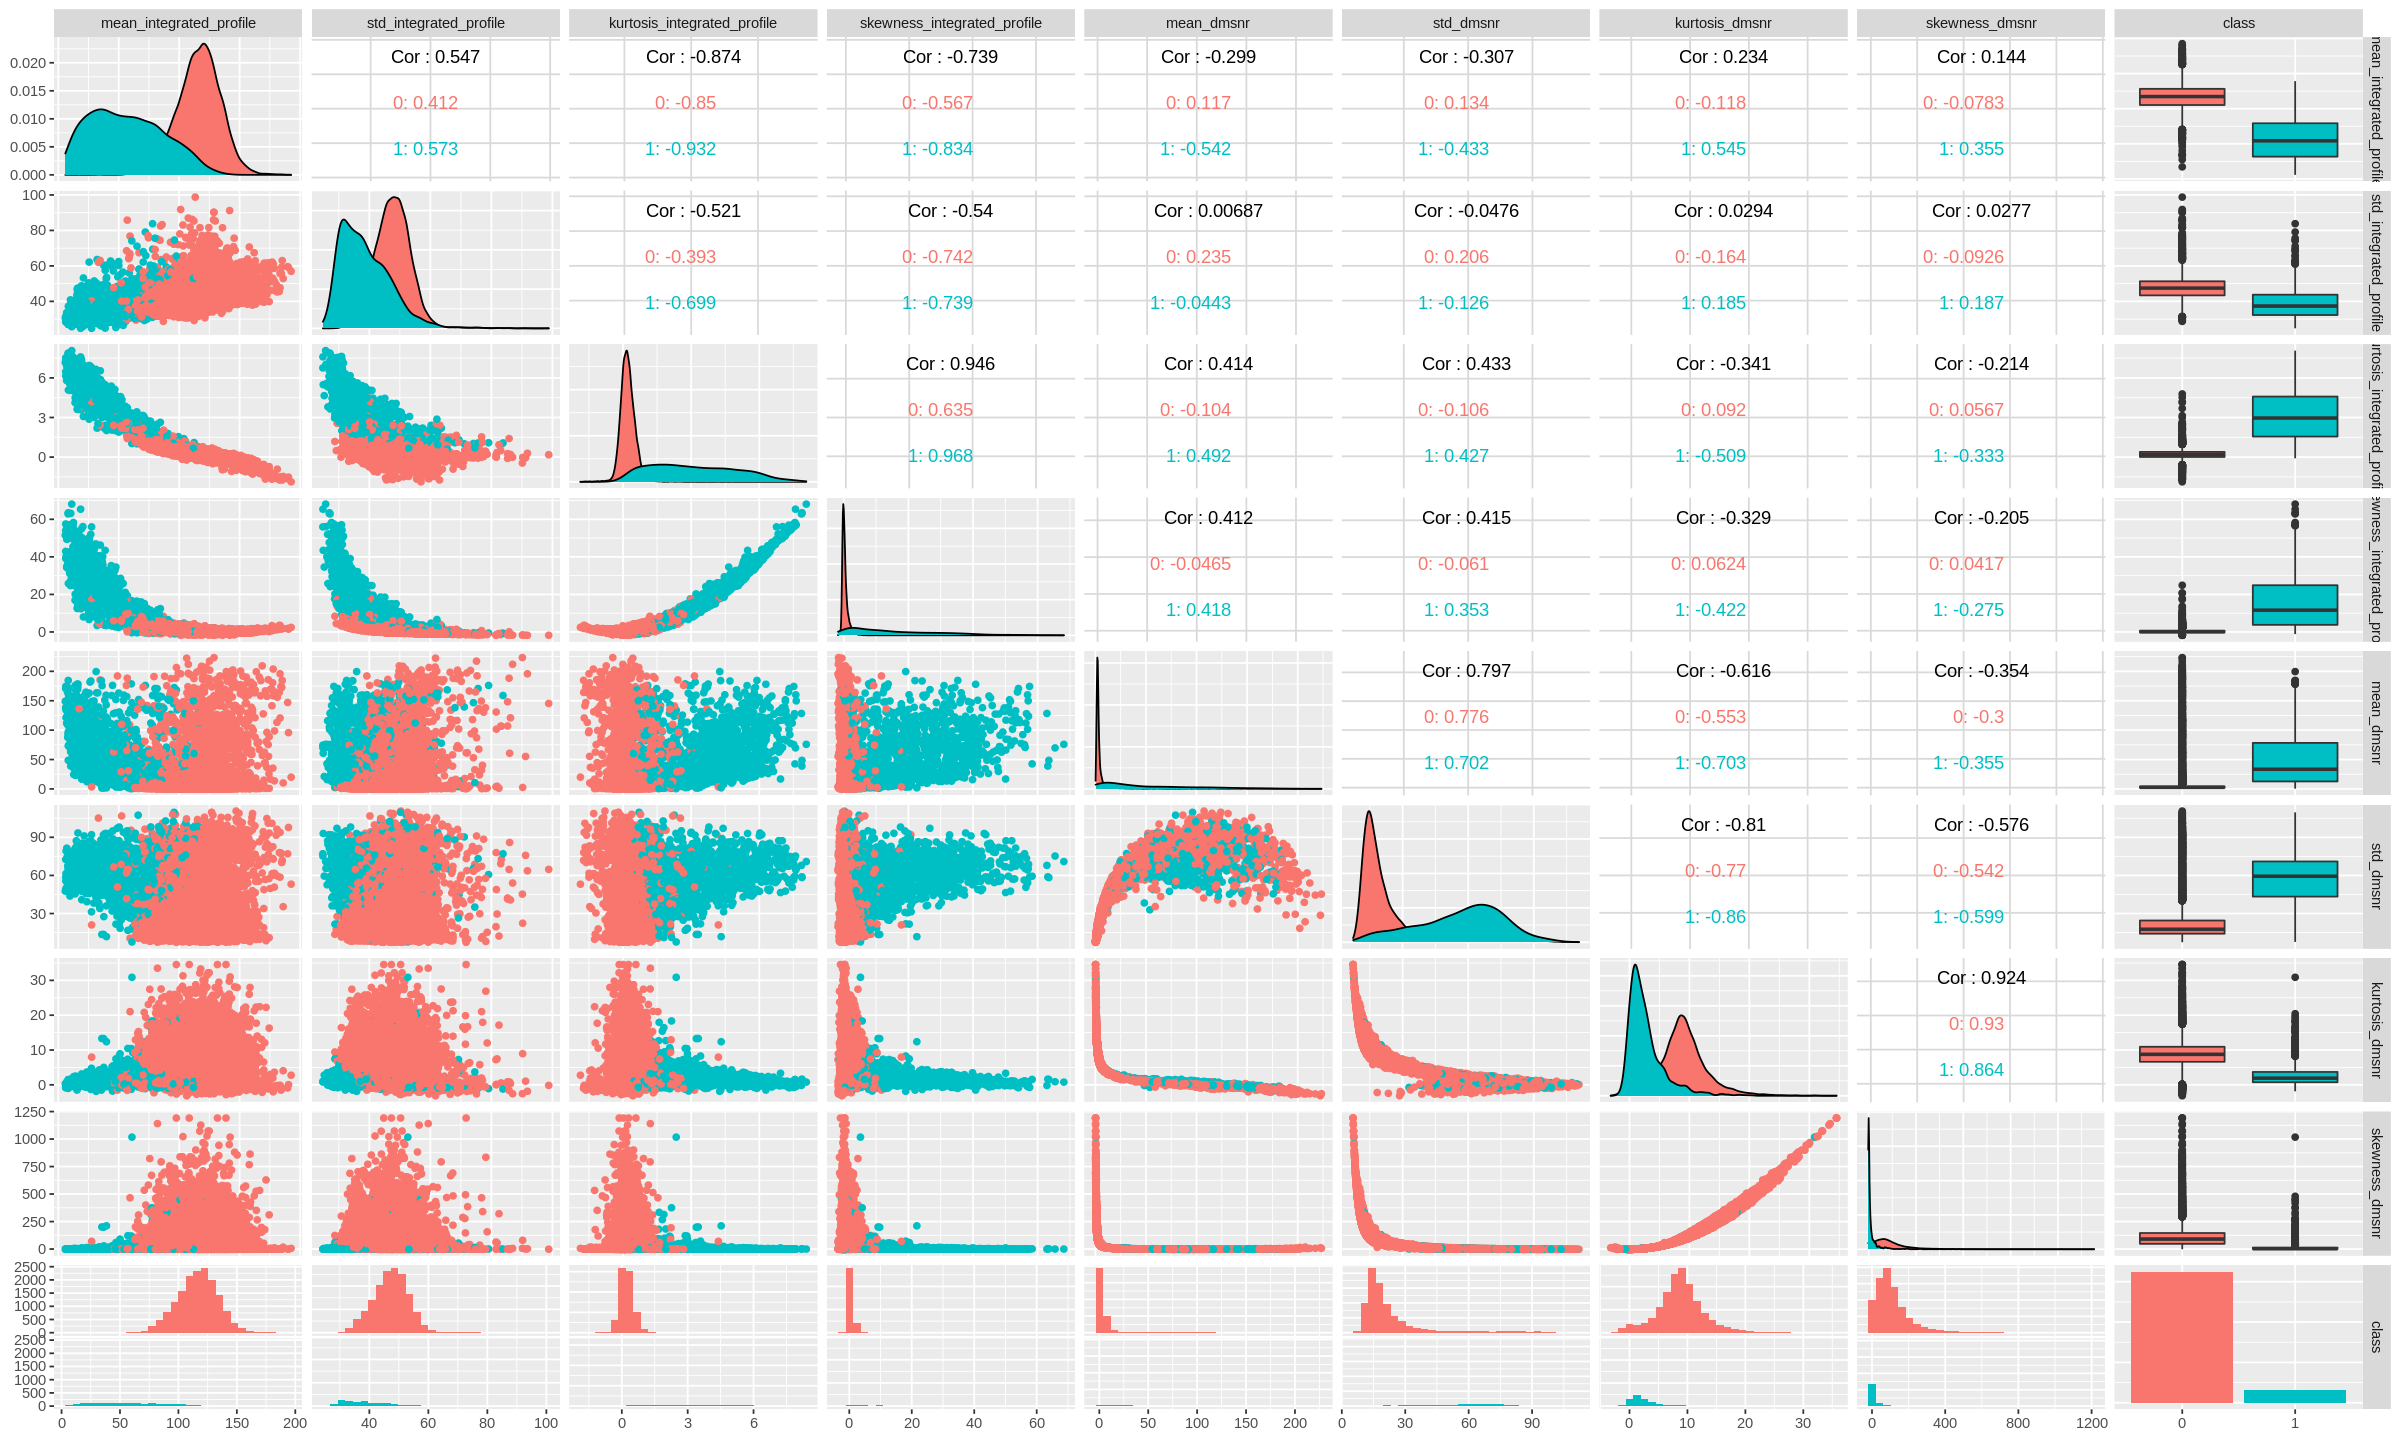

In [23]:
options(repr.plot.width=20, repr.plot.height=12)

pulsar %>% ggpairs(aes(color=class))

Distinguishing the two target classes by color (coral and teal), the graphs above show the distributions of observations for each class when plotted against other variables. The smoothed line plots in particular provide clear indications for the degree of difference between observations belonging to different classes. Observing the graphs presents that out of all eight features considered, Pulsar and non-Pulsar stars differ most significantly in kurtosis_integrated_profile, skewness_integrated_profile, mean_dmsnr, std_dmsnr, and skewness_dmsnr. Therefore, these features are more likely to be useful classifiers for the purpose of this project.

## Training Testing Split

First, before scaling data, let's split the data into a training-testing split. We decided to use a 70-30 training-testing split because we have quite a lot of data to work with, which means that sufficient data will be part of the testing split, even if only 30% of it is taken for the testing split.

In [24]:
# Make a 80-20 split
pulsar_split <- initial_split(pulsar, strata=class, prop=7/10)
pulsar_training <- training(pulsar_split)
pulsar_testing <- testing(pulsar_split)

ERROR: Error in initial_split(pulsar, strata = class, prop = 7/10): could not find function "initial_split"


## Feature Scaling

Some features have massively different scales from each other. For instance, the `skewness_dmsnr` feature has a scale up to thousands, while the `kurtosis_integrated_profile` feature only ranges between -3 to 9. This calls for feature scaling, to make sure the model can interpret every single observation according to a uniform scale. This process will be done together with the forward pass feature selection.

## Model Specification and Feature Selection

We will use the k-nearest neighbors model for the classification task. To further improve model performance, we will conduct feature selection using the forward pass method and perform a 5-fold cross-validation to assess the different models' performances.

In [ ]:
# Model Specification
knn_model <- nearest_neighbor(weight_func='rectangular', neighbors=tune()) %>%
            set_mode('classification') %>%
            set_engine('kknn')

# Create the 5-fold vfold object
pulsar_vfold <- vfold_cv(pulsar_training, v=5, strata=class)

We will then create a tibble that stores the model formula (target variable ~ predictors) and the accuracy achieved when using that formula. Then, we can perform forward passes.

Note:
Since the positive and negative class are heavily imbalanced, we will use `step_upsample` to upsample the very sparse positive class to make the model more robust

In [ ]:
# Tibble storing model and accuracy data
accuracies <- tibble(no=integer(), model_formula=character(), accuracy=numeric())

predictors <- columns_except_class
selected <- c()

for (i in 1:length(predictors)) {
    accuracy <- c()
    model <- c()
    for (j in 1:length(predictors)) {
        #Create a model formula using these predictors
        new_predictors <- c(selected, predictors[[j]])
        model_formula <- paste("class", "~", paste(new_predictors, collapse="+"))
        
        #Create the model recipe
        pulsar_recipe <- pulsar_training %>%
                            recipe(as.formula(model_formula)) %>%
                            step_scale(all_predictors()) %>%
                            step_center(all_predictors()) %>%
                            step_upsample(class, over_ratio=1, skip=TRUE)
        
        #Tune the model with these predictors, find the best k value, and print the accuracy
        metrics <- workflow() %>%
                        add_model(knn_model) %>%
                        add_recipe(pulsar_recipe) %>%
                        tune_grid(resamples= pulsar_vfold) %>%
                        collect_metrics() %>%
                        filter(.metric == "accuracy") 
        
        acc <- metrics %>%
                summarize(mean_accuracy=mean(mean)) %>%
                pull(mean_accuracy)
        
        accuracy[[j]] <- acc
        model[[j]] <- model_formula 
    }
    best_accuracy_i_preds_index <- which.max(accuracy)
    accuracies <- accuracies %>% 
                    add_row(no=i, 
                             model_formula = model[[best_accuracy_i_preds_index]],
                             accuracy = accuracy[[best_accuracy_i_preds_index]])
    selected <- c(selected, predictors[[best_accuracy_i_preds_index]])
    predictors <- predictors[-best_accuracy_i_preds_index]
}

accuracies

According to the table above, the best model is model 5 with the highest accuracy (approximately 0.95). Note the features employed by this model are exactly the ones that were previously observed to differ the most between Pulsar and non-Pulsar stars. We now use this 'best model' and retrain it with cross_validation to find the best k value.

In [1]:
model_recipe <- pulsar_training %>%
                    recipe(class ~ kurtosis_integrated_profile+skewness_dmsnr+std_dmsnr+skewness_integrated_profile+mean_dmsnr) %>%
                    step_scale(all_predictors()) %>%
                    step_center(all_predictors()) %>%
                    step_upsample(class, skip=TRUE, over_ratio = 1)

knn_cross_val <- nearest_neighbor(weight_func="rectangular", neighbors=tune()) %>%
                    set_mode("classification") %>%
                    set_engine("kknn")

vfold_pulsar <- vfold_cv(pulsar_training, v=5, strata=class)

accuracies <- workflow() %>% 
            add_model(knn_cross_val) %>%
            add_recipe(model_recipe) %>%
            tune_grid(resamples=vfold_pulsar, grid=20) %>%
            collect_metrics() %>%
            filter(.metric == "accuracy")

accuracies

ERROR: Error in pulsar_training %>% recipe(class ~ kurtosis_integrated_profile + : could not find function "%>%"


From the table, we pick k = 3. While k = 1 and 2  had higher accuracy results, this would likely be a situation where the model would overfit, which isn't something that we want.

## Finalizing the Model and Evaluating Accuracy

With all the information needed for our final model, we can now construct the 'best model' and assess its accuracy using the test data and an output confusion matrix.

In [ ]:
best_model <- nearest_neighbor(weight_func='rectangular', neighbors=3) %>%
                set_mode("classification") %>%
                set_engine("kknn")

truth_and_estimate <- workflow() %>% add_recipe(model_recipe) %>%
                        add_model(best_model) %>%
                        fit(pulsar_training) %>%
                        predict(pulsar_testing) %>%
                        bind_cols(pulsar_testing) 

accuracy <- truth_and_estimate %>% 
                metrics(truth=class, estimate=.pred_class)

conf_matrix <- truth_and_estimate %>%
                    conf_mat(truth=class, estimate=.pred_class)
                

print(conf_matrix)
accuracy

## Results
The output indicates this algorithm predicted approximately 96.29% of the observations into correct classes with 4740 true positives, 144 false positives, 55 false negatives and 431 true negatives. 

## Discussion

### Summary of Our Findings
Based on our analysis above, we conclude that the K-nearest neighbor classification algorithm built using the HTRU2 dataset is effective in predicting a given data signal as pulsar or non-pulsar. The most optimal model we constructed uses parameter k = 3 and contains five classifiers: the excess kurtosis and skewness of the integrated profile P, as well as the mean, standard deviation, and skewness of the DM-SNR curve D. The model also demonstrates 96.29% prediction accuracy when tested against the test data. All of these results agree with our initial prediction. As useful classifiers for an observation’s class, the five features listed above must exhibit close relationships with the target variable. **We therefore confirm that based on the HTRU2 dataset, characteristics of a data signal’s integrated profile and DM-SNR curve can be utilized to classify observations as pulsar or non-pulsar stars with high accuracy.**

Furthermore, to better evaluate the exactitude of our classification algorithm in the context of this application, we compare its prediction accuracy of 96.29% with the precisions of more sophisticated models from other sources. The work of Lyon et al. assesses the same dataset using five different algorithms, with accuracy levels shown below:

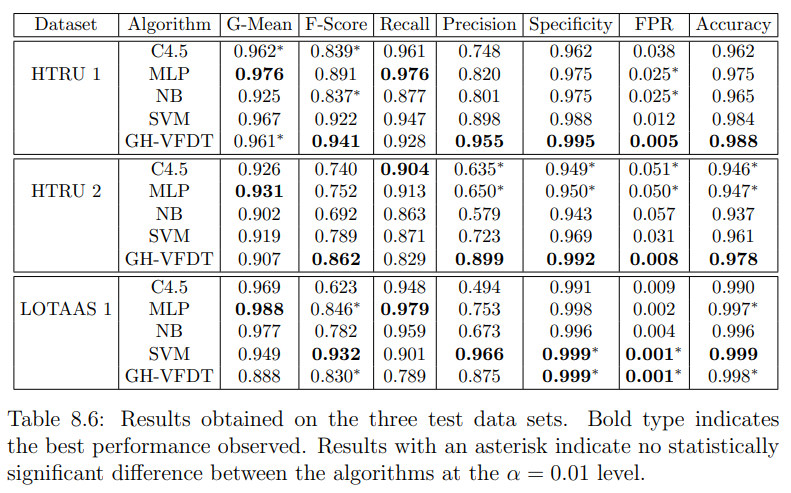

*Note. From “Why are pulsars hard to find?” by Lyon, R. J., Knowles, J., Brooke, J., & Stappers, B. (n.d.). (thesis), p. 235*


Compared with Lyon et al.’s results, our model’s accuracy is indeed sufficient to support our previous prediction and answer our initial research question. 

### Expectations, Significance, and Future Questions

Our expectation for this project is to successfully differentiate the class 0 and 1 variables by constructing both scatter plots and histograms using the HTRU2 dataset. As shown above, our findings have matched our assumption of the characteristics of a data signal’s integrated profile and DM-SNR can be used to classify pulsar and non-pulsar and also be used in prediction. 

This finding provides further impact for the researchers to correctly differentiate pulsar and non-pulsar and make further predictions. Furthermore, it also helps researchers to have an overall idea of the value of integrated profile and DM-SNR when they observe a pulsar star. Based on our results, we are interested in discovering the future question of what is the relationship between integrated profile and DM-SNR of pulsar? How about non-pulsar? 

Lastly, we have learned that all pulsars have their unique profile shape, which is like human fingerprints. From this feature, we are interested in a future question of what is the relationship between each variable in the data set?


## References

R. J. Lyon. HTRU2 (Version number) [Data file]. Retrieved from http://archive.ics.uci.edu/ml/datasets/HTRU2

Lyon, R. J., Knowles, J., Brooke, J., & Stappers, B. (n.d.). *Why are pulsars hard to find?* (thesis). 


Lorimer, D. R., & Kramer, M. (2004). *Handbook of Pulsar Astronomy* (τ. 4).

